# Experiment

TODO Explanation

In [1]:
# Install all required packages
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [70]:
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import GmGM
import warnings
import seaborn as sns
import scipy.sparse as sparse
import pandas as pd
import anndata as ad
import igraph as ig
from typing import Optional, Literal
from sklearn.covariance import graphical_lasso as glasso
from sklearn.preprocessing import StandardScaler

plt.style.use('tableau-colorblind10')

We'll use this dataset:
    [Spatio-temporal immune zonation of the human kidney](https://www.ebi.ac.uk/gxa/sc/experiments/E-HCAD-10/results/tsne)

It has ~30,000 cells, which is about as large as we can reasonably expect people to be able to download during a workshop.  Downloading it will take a few minutes, but once its downloaded it will 

In [3]:
# This establishes the directory that the data will be saved to
sc._settings.ScanpyConfig.datasetdir = Path('../data/')
adata = sc.datasets.ebi_expression_atlas(
    accession='E-HCAD-10',
)
adata

AnnData object with n_obs × n_vars = 31711 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individu

The gene names are stored as ENSG codes, so let's get the external gene names as well!

In [4]:
mapping = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "external_gene_name"]
)
mapping = mapping.set_index("ensembl_gene_id")
mapping = mapping[mapping.index.isin(adata.var_names)]

# Add to adata
adata.var["external_gene_name"] = "Not in Biomart"
adata.var.loc[adata.var_names.isin(mapping.index), "external_gene_name"] = mapping["external_gene_name"]
adata.var[adata.var["external_gene_name"].isna()] = "Biomart NaN"

In [5]:
adata.var["external_gene_name"]

ENSG00000000003                     TSPAN6
ENSG00000000005                       TNMD
ENSG00000000419                       DPM1
ENSG00000000457                      SCYL3
ENSG00000000460                      FIRRM
                            ...           
ENSG00000289695                Biomart NaN
ENSG00000289697                Biomart NaN
ENSG00000289700                Biomart NaN
ENSG00000289701                Biomart NaN
ENSG00000289716    XNDC1N-ZNF705EP-ALG1L9P
Name: external_gene_name, Length: 26385, dtype: object

In [6]:
adata.obs['inferred cell type'] = adata.obs['Factor Value[inferred cell type - authors labels]'].cat.add_categories("unknown").fillna("unknown")
adata.obs['inferred cell type']

4834STDY7002875_S1_L001-AAAATGAAGCCAGTAG                      unknown
4834STDY7002875_S1_L001-AAACCAATCTTCGGTC                      unknown
4834STDY7002875_S1_L001-AAACCTATCAACACAC                      unknown
4834STDY7002875_S1_L001-AAACCTATCAGAAATG                      unknown
4834STDY7002875_S1_L001-AAACCTCAGGAGCGAG                      unknown
                                                      ...            
FCAImmP7579215_S1_L001-TTTGTCAAGATATGGT     distal renal vesicle cell
FCAImmP7579215_S1_L001-TTTGTCAAGGAGTCTG                       unknown
FCAImmP7579215_S1_L001-TTTGTCACACAGCGTC           cap mesenchyme cell
FCAImmP7579215_S1_L001-TTTGTCACATTAACCG             fibroblast type 1
FCAImmP7579215_S1_L001-TTTGTCATCATGTCTT             stroma progenitor
Name: inferred cell type, Length: 31711, dtype: category
Categories (45, object): ['B cell', 'CD4+ T cell', 'CD8+ T cell', 'cap mesenchyme cell', ..., 'proximal renal vesicle cell', 'proximal ureteric bud cell', 'stroma progenitor

# Preprocessing

Here we will do some simple preprocessing of the data.  The goal will be to remove low-quality cells and genes; we will also log-transform the data.

For this we can rely on the `scanpy` library, which fills the niche in Python that Seurat does in R.

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

AnnData object with n_obs × n_vars = 31711 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individu

In [8]:
# Quality Control Cutoffs
# feel free to change! they are fairly arbitrary

# Keep cells who are expressed in at least __ genes
n_genes_by_counts_cutoff = 1000

# Keep cells who have a total expression of ___ when summed across all genes
cells_total_counts_cutoff = 10_000

# Keep genes who are expressed in at least __ cells
n_cells_by_counts_cutoff = 1000

# Keep cells who have a total expression of ___ when summed across all cells
genes_total_counts_cutoff = 50_000

8884 cells kept (28.02%)
687 genes kept (2.17%)


View of AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[ind

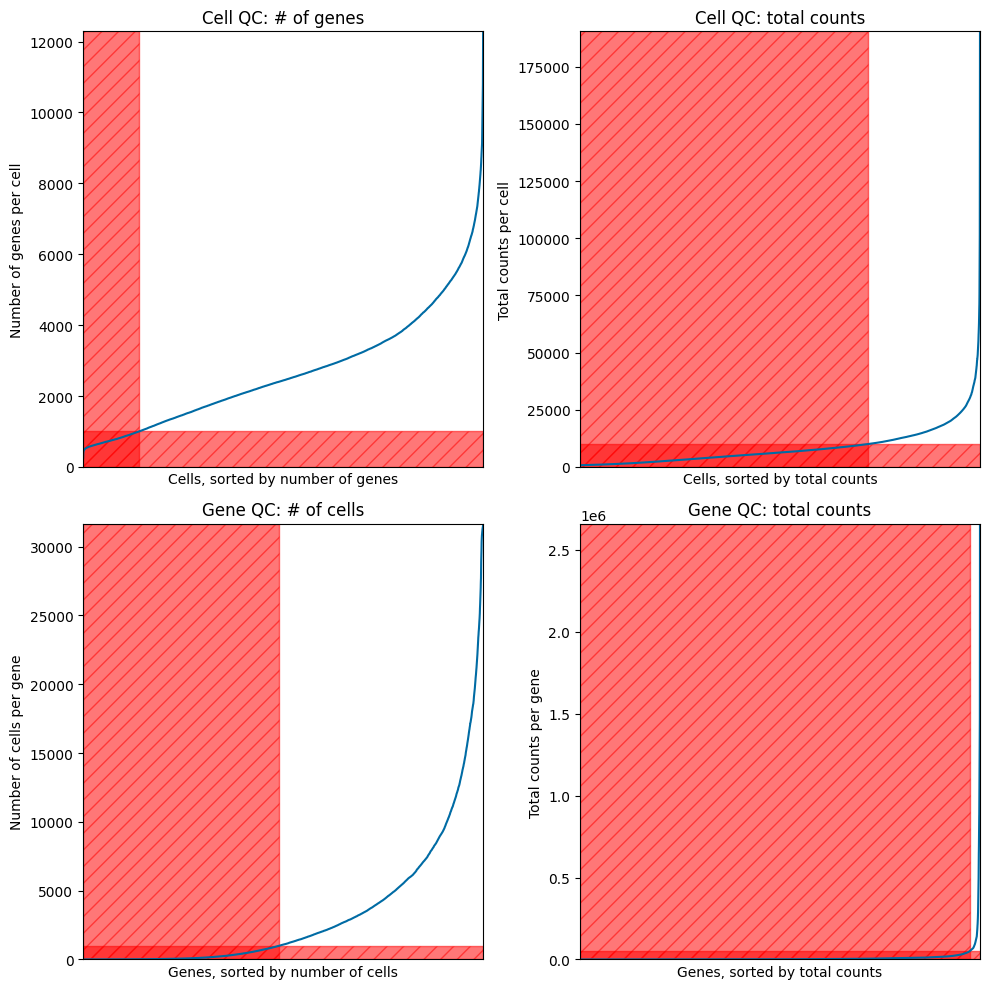

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axs.flatten()

# Number of genes
adata.obs['n_genes_by_counts'].sort_values().plot(ax=ax1)
ax1.set_xticks([])
ax1.set_ylabel("Number of genes per cell")
ax1.set_xlabel("Cells, sorted by number of genes")
ax1.set_title("Cell QC: # of genes")
ax1.set_ylim(0, adata.obs['n_genes_by_counts'].max())
ax1.set_xlim(0, adata.obs['n_genes_by_counts'].shape[0])
ax1.axhspan(0, n_genes_by_counts_cutoff, color="#FF000088", hatch='//')
cells_keep_1 = ~(adata.obs['n_genes_by_counts'] < n_genes_by_counts_cutoff)
ax1.axvspan(0, (~cells_keep_1).sum(), color="#FF000088", hatch='//')

# Total counts of genes
adata.obs['total_counts'].sort_values().plot(ax=ax2)
ax2.set_xticks([])
ax2.set_ylabel("Total counts per cell")
ax2.set_xlabel("Cells, sorted by total counts")
ax2.set_title("Cell QC: total counts")
ax2.set_ylim(0, adata.obs['total_counts'].max())
ax2.set_xlim(0, adata.obs['total_counts'].shape[0])
ax2.axhspan(0, cells_total_counts_cutoff, color="#FF000088", hatch='//')
cells_keep_2 = ~(adata.obs['total_counts'] < cells_total_counts_cutoff)
ax2.axvspan(0, (~cells_keep_2).sum(), color="#FF000088", hatch='//')

# Number of cells
adata.var['n_cells_by_counts'].sort_values().plot(ax=ax3)
ax3.set_xticks([])
ax3.set_ylabel("Number of cells per gene")
ax3.set_xlabel("Genes, sorted by number of cells")
ax3.set_title("Gene QC: # of cells")
ax3.set_ylim(0, adata.var['n_cells_by_counts'].max())
ax3.set_xlim(0, adata.var['n_cells_by_counts'].shape[0])
ax3.axhspan(0, n_cells_by_counts_cutoff, color="#FF000088", hatch='//')
genes_keep_1 = ~(adata.var['n_cells_by_counts'] < n_cells_by_counts_cutoff)
ax3.axvspan(0, (~genes_keep_1).sum(), color="#FF000088", hatch='//')

# Total counts of cells
adata.var['total_counts'].sort_values().plot(ax=ax4)
ax4.set_xticks([])
ax4.set_ylabel("Total counts per gene")
ax4.set_xlabel("Genes, sorted by total counts")
ax4.set_title("Gene QC: total counts")
ax4.set_ylim(0, adata.var['total_counts'].max())
ax4.set_xlim(0, adata.var['total_counts'].shape[0])
ax4.axhspan(0, genes_total_counts_cutoff, color="#FF000088", hatch='//')
genes_keep_2 = ~(adata.var['total_counts'] < genes_total_counts_cutoff)
ax4.axvspan(0, (~genes_keep_2).sum(), color="#FF000088", hatch='//')

fig.tight_layout()

cells_keep = cells_keep_1 & cells_keep_2
genes_keep = genes_keep_1 & genes_keep_2
print(f"{cells_keep.sum()} cells kept ({cells_keep.sum()/adata.shape[0]:.2%})")
print(f"{genes_keep.sum()} genes kept ({genes_keep.sum()/adata.shape[0]:.2%})")

# Filter the adata
fadata = adata[cells_keep, genes_keep]
fadata

In [10]:
# Log transform (in place)
sc.pp.log1p(adata)
sc.pp.log1p(fadata)
fadata

/home/codespace/.python/current/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:401: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individual]

# Visualization

In [11]:
# Parameters (feel free to change these)
N_COMPS = 50
N_NEIGHBORS = 10

Text(0.5, 1.0, 'Explained variance of filtered dataset (cells)')

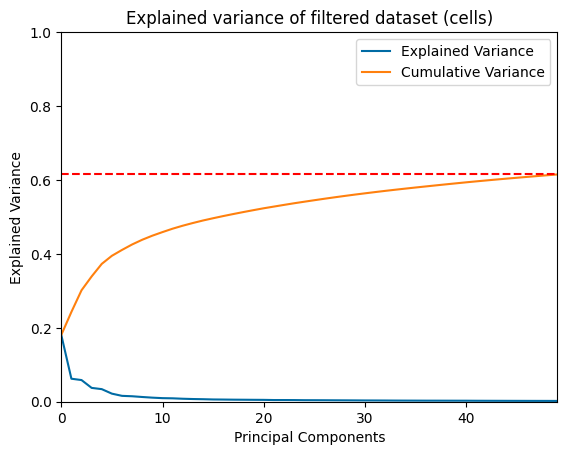

In [12]:
sc.pp.pca(fadata, n_comps=N_COMPS)

fig, ax = plt.subplots()
explained_variance = fadata.uns['pca']['variance_ratio']
ax.plot(explained_variance, label="Explained Variance")
ax.plot(explained_variance.cumsum(), label="Cumulative Variance")

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")

ax.set_xlim(0, N_COMPS - 1)
ax.set_ylim(0, 1)

ax.axhline(explained_variance.cumsum().max(), linestyle='--', color='red')
ax.legend()

ax.set_title("Explained variance of filtered dataset (cells)")

In [13]:
# Should take around a minute to run
sc.pp.neighbors(fadata, n_neighbors=N_NEIGHBORS)
sc.tl.umap(fadata)

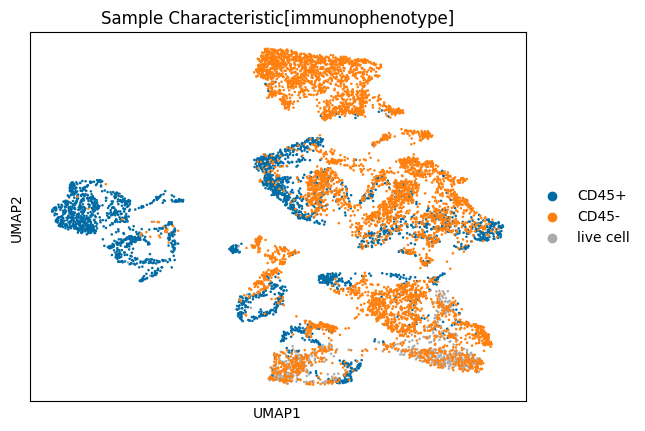

In [14]:
sc.pl.umap(fadata, color=['Sample Characteristic[immunophenotype]'])

In [15]:
# Let's look at the genes now!
fbdata = fadata.transpose()

Text(0.5, 1.0, 'Explained variance of filtered dataset (genes)')

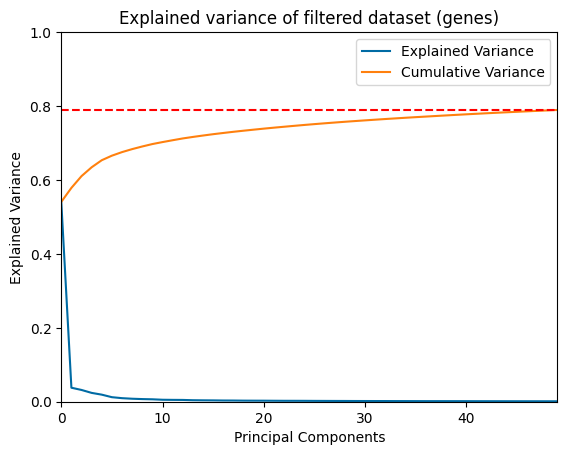

In [16]:
sc.pp.pca(fbdata, n_comps=N_COMPS)

fig, ax = plt.subplots()
explained_variance = fbdata.uns['pca']['variance_ratio']
ax.plot(explained_variance, label="Explained Variance")
ax.plot(explained_variance.cumsum(), label="Cumulative Variance")

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")

ax.set_xlim(0, N_COMPS - 1)
ax.set_ylim(0, 1)

ax.axhline(explained_variance.cumsum().max(), linestyle='--', color='red')
ax.legend()

ax.set_title("Explained variance of filtered dataset (genes)")

In [17]:
# Should be very quick to run
sc.pp.neighbors(fbdata, n_neighbors=N_NEIGHBORS)
sc.tl.umap(fbdata)

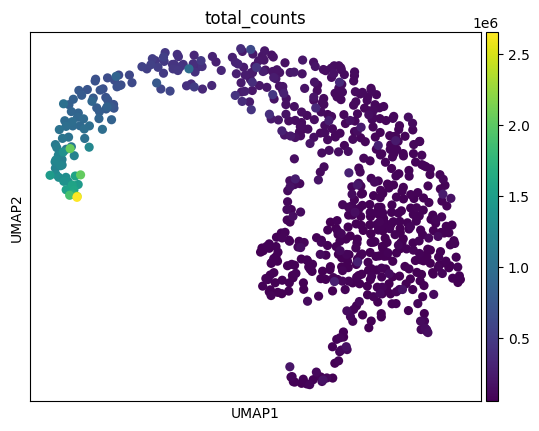

In [18]:
sc.pl.umap(fbdata, color=['total_counts'])

# Graphical Models

## GmGM

In [19]:
# Note that GmGM natively accepts AnnData and MuData, i.e. we could pass
# fadata into the algorithm directly, rather than wrapping it
# in `GmGM.Dataset`.  However more general datastructures need to be wrapped,
# so in this tutorial we will use the most general way

dataset = GmGM.Dataset(
    dataset={"data": fadata.X},
    structure={"data": ("cell", "gene")}
)

output = GmGM.GmGM(
    dataset,
    to_keep=N_NEIGHBORS, # how many edges per cell (on average) should we keep
    threshold_method="overall-col-weighted", # method of keeping top genes
    min_edges={"cell": 5, "gene": 3}, # to ensure the graphs have no singletons
    n_comps=N_COMPS, # number of principal components to use
    centering_method=None,
    use_nonparanormal_skeptic=True, # account for non-Gaussian marginals
    nonparanormal_evec_backend='COCA',
    calculate_explained_variance=True,
    batch_size=1000, # making this smaller for very large datasets may save memory
    verbose=True,
)

/home/codespace/.python/current/lib/python3.10/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set data's tensor of type <class 'scipy.sparse._csr.csr_matrix'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(


Centering...
Calculating eigenvectors...
	by calculating left eigenvectors and applying a rank-one update...
		Computing sparse normal map for axis='cell'...
		...Done computing sparse normal map
		Explained variance for axis='cell': 66.5551%
		Computing sparse normal map for axis='gene'...
		...Done computing sparse normal map
		Explained variance for axis='gene': 81.7529%
Calculating eigenvalues...
@0: 7373066.09017819 (-1777.9948359319503 + 7374844.085014122 + 0) ∆inf
Converged! (@17: 4330048.1159756845)
Recomposing sparse precisions...
Done!


In [20]:
# Now add the results to our AnnData objects
fadata.obsp['cell_gmgm'] = sparse.csr_matrix(output.precision_matrices['cell'])
fadata.varp['gene_gmgm'] = sparse.csr_matrix(output.precision_matrices['gene'])

fbdata.varp['cell_gmgm'] = sparse.csr_matrix(output.precision_matrices['cell'])
fbdata.obsp['gene_gmgm'] = sparse.csr_matrix(output.precision_matrices['gene'])

# Also add it to dataset that has all genes, so that we can
# later look at gene expression of out-filtered genes!
gadata = adata[cells_keep]
gadata.obsp['cell_gmgm'] = sparse.csr_matrix(output.precision_matrices['cell'])
gadata.obsm['X_umap'] = fadata.obsm['X_umap']

/tmp/ipykernel_2612/2099670428.py:11: ImplicitModificationWarning: Setting element `.obsp['cell_gmgm']` of view, initializing view as actual.
  gadata.obsp['cell_gmgm'] = sparse.csr_matrix(output.precision_matrices['cell'])


## Graphical Lasso

As a default, we manually tuned the regularization parameter (alpha) to yield a graph of similar sparsity to the GmGM results, for the fairest comparison.

In [80]:
nonzero = (fbdata.obsp['gene_gmgm'] != 0).sum()
percentage = nonzero / fbdata.obsp['gene_gmgm'].shape[0]**2
print(f"Percentage nonzero elements: {percentage}")

Percentage nonzero elements: 0.017954569050085918


In [100]:
# Calculating the cell graph takes too long!
# So we will just look at the gene graph.  We found this very finnicky to set up, hence how much
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = fadata.X.toarray().T
data = StandardScaler().fit_transform(data)
emp_cov = data @ data.T

# Due to numerical issues, the covariance matrix always has seems to have a negative eigenvalue;
# this should not happen, and needs to be fixed otherwise it does not actually constitute a real
# covariance matrix.  GLasso crashes because it is not positive-semi-definite...
# We will fix this by manually setting the eigenvalue to zero
eigs = np.linalg.eigh(emp_cov)
evals = eigs.eigenvalues
evecs = eigs.eigenvectors
evals[evals < 0] = 0
emp_cov = (evecs * evals) @ evecs.T

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.965,
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
percentage = (goutput[1] != 0).sum() / emp_cov.shape[0]**2
print(f"Percentage nonzero elements: {percentage}")

Percentage nonzero elements: 0.0178168481404499


In [101]:
# Now add the results to our AnnData objects
fadata.varp['gene_glasso'] = sparse.csr_matrix(np.abs(goutput[1]))
fbdata.obsp['gene_glasso'] = sparse.csr_matrix(np.abs(goutput[1]))

# Evaluate Results

In [102]:
# Run Leiden clustering
sc.tl.leiden(fadata, obsp='cell_gmgm', key_added='leiden_gmgm')
sc.tl.leiden(gadata, obsp='cell_gmgm', key_added='leiden_gmgm')
sc.tl.leiden(fbdata, obsp='gene_gmgm', key_added='leiden_gmgm')
sc.tl.leiden(fbdata, obsp='gene_glasso', key_added='leiden_glasso')
fadata

AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individual]

In [103]:
# GLasso (and other models that use L1 penalty) tend to result in lots of singletons
# so we'll squash all the lonely genes into one "Singleton" cluster
singleton_idxs = fbdata.obs['leiden_glasso'].value_counts() == 1

# Clusters are ordered by size
first_singleton_cluster = fbdata.obs['leiden_glasso'].value_counts()[singleton_idxs].index.astype(int).min()


idxs = fbdata.obs['leiden_glasso'].astype(int) >= first_singleton_cluster
fbdata.obs['leiden_glasso'] = fbdata.obs['leiden_glasso'].cat.add_categories('Singleton')
fbdata.obs.loc[idxs, 'leiden_glasso'] = 'Singleton'
fbdata.obs['leiden_glasso'] = fbdata.obs['leiden_glasso'].cat.remove_unused_categories()
fbdata.obs['leiden_glasso'].value_counts()

leiden_glasso
Singleton    584
0             86
1              5
2              2
3              2
4              2
5              2
6              2
7              2
Name: count, dtype: int64

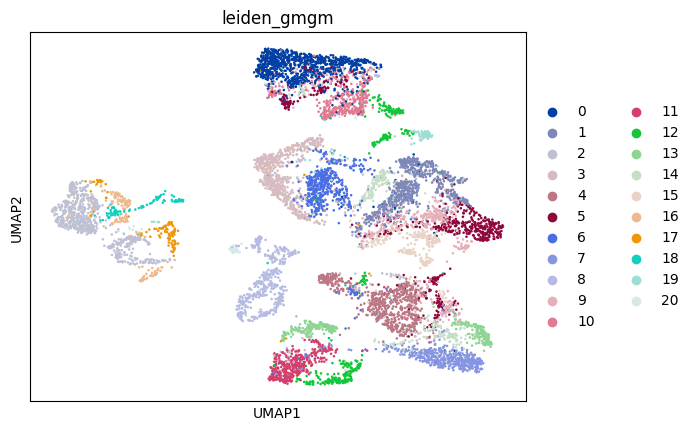

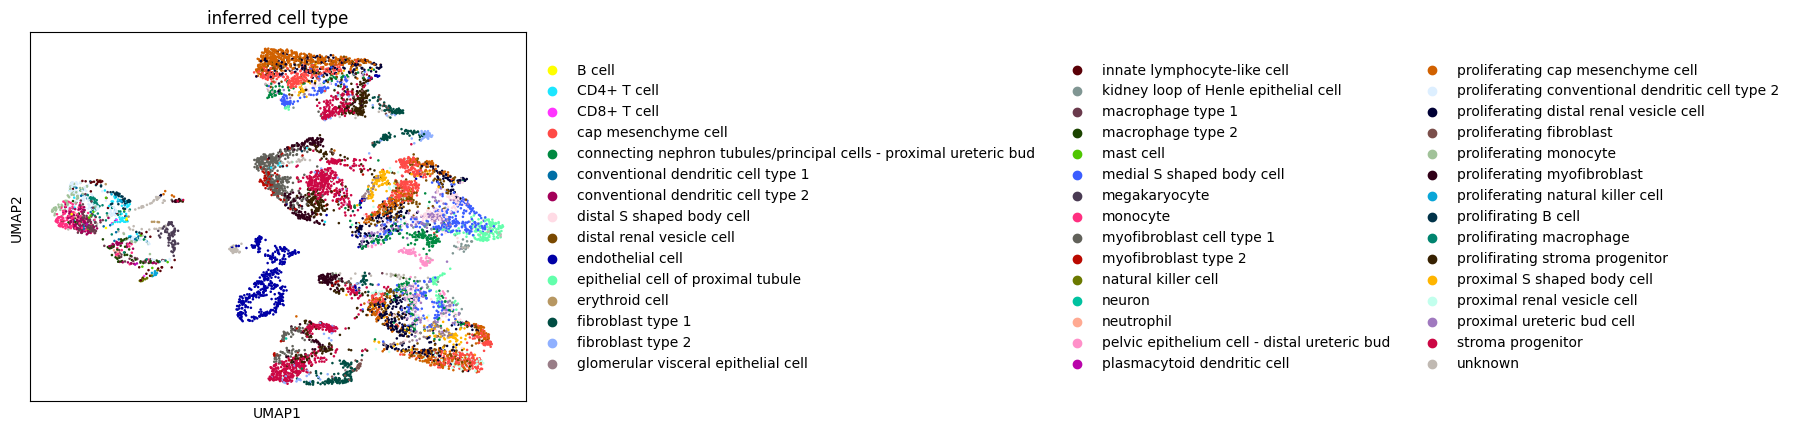

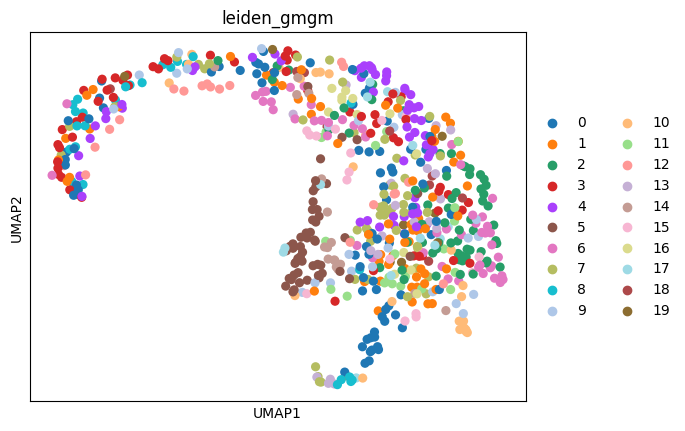

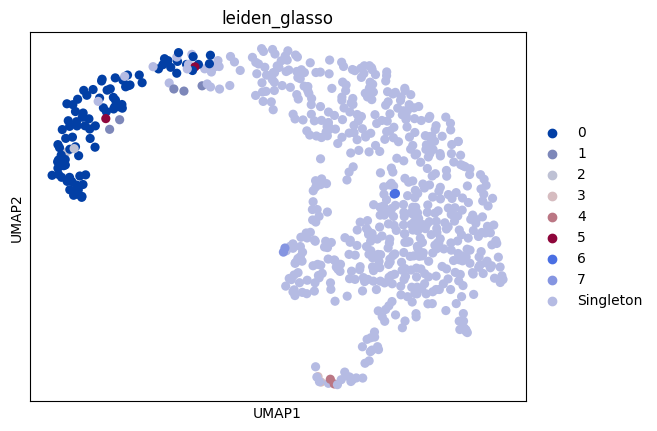

In [104]:
sc.pl.umap(gadata, color=['leiden_gmgm'])
sc.pl.umap(gadata, color=['inferred cell type'])
sc.pl.umap(fbdata, color=['leiden_gmgm'])
sc.pl.umap(fbdata, color=['leiden_glasso'])

# Cell Analysis

In [105]:
def jaccard(x: set, y: set) -> float:
    return len(x & y) / len(x | y)

def dice(x: set, y: set) -> float:
    return 2 * len(x & y) / (len(x) + len(y))

def overlap(x: set, y: set) -> float:
    return len(x & y) / min(len(x), len(y))

def get_overlap(x: set, y: set, OVERLAP_METHOD: str) -> float:
    if OVERLAP_METHOD == "overlap":
        return overlap(x, y)
    elif OVERLAP_METHOD == "dice":
        return dice(x, y)
    elif OVERLAP_METHOD == "jaccard":
        return jaccard(x, y)
    else:
        raise ValueError(f"Unknown method {OVERLAP_METHOD}")    

In [106]:
OVERLAP_METHOD = "overlap"

# Create confusion matrix
confusion = np.zeros((
    gadata.obs['leiden_gmgm'].nunique(),
    gadata.obs['inferred cell type'].nunique()
))

for my_cluster in gadata.obs['leiden_gmgm'].unique():
    i = int(my_cluster)
    for j, cell_type in enumerate(gadata.obs['inferred cell type'].unique()):
        confusion[i, j] = get_overlap(
            set(gadata[gadata.obs["leiden_gmgm"] == my_cluster].obs_names),
            set(gadata[gadata.obs['inferred cell type'] == cell_type].obs_names),
            OVERLAP_METHOD
        )

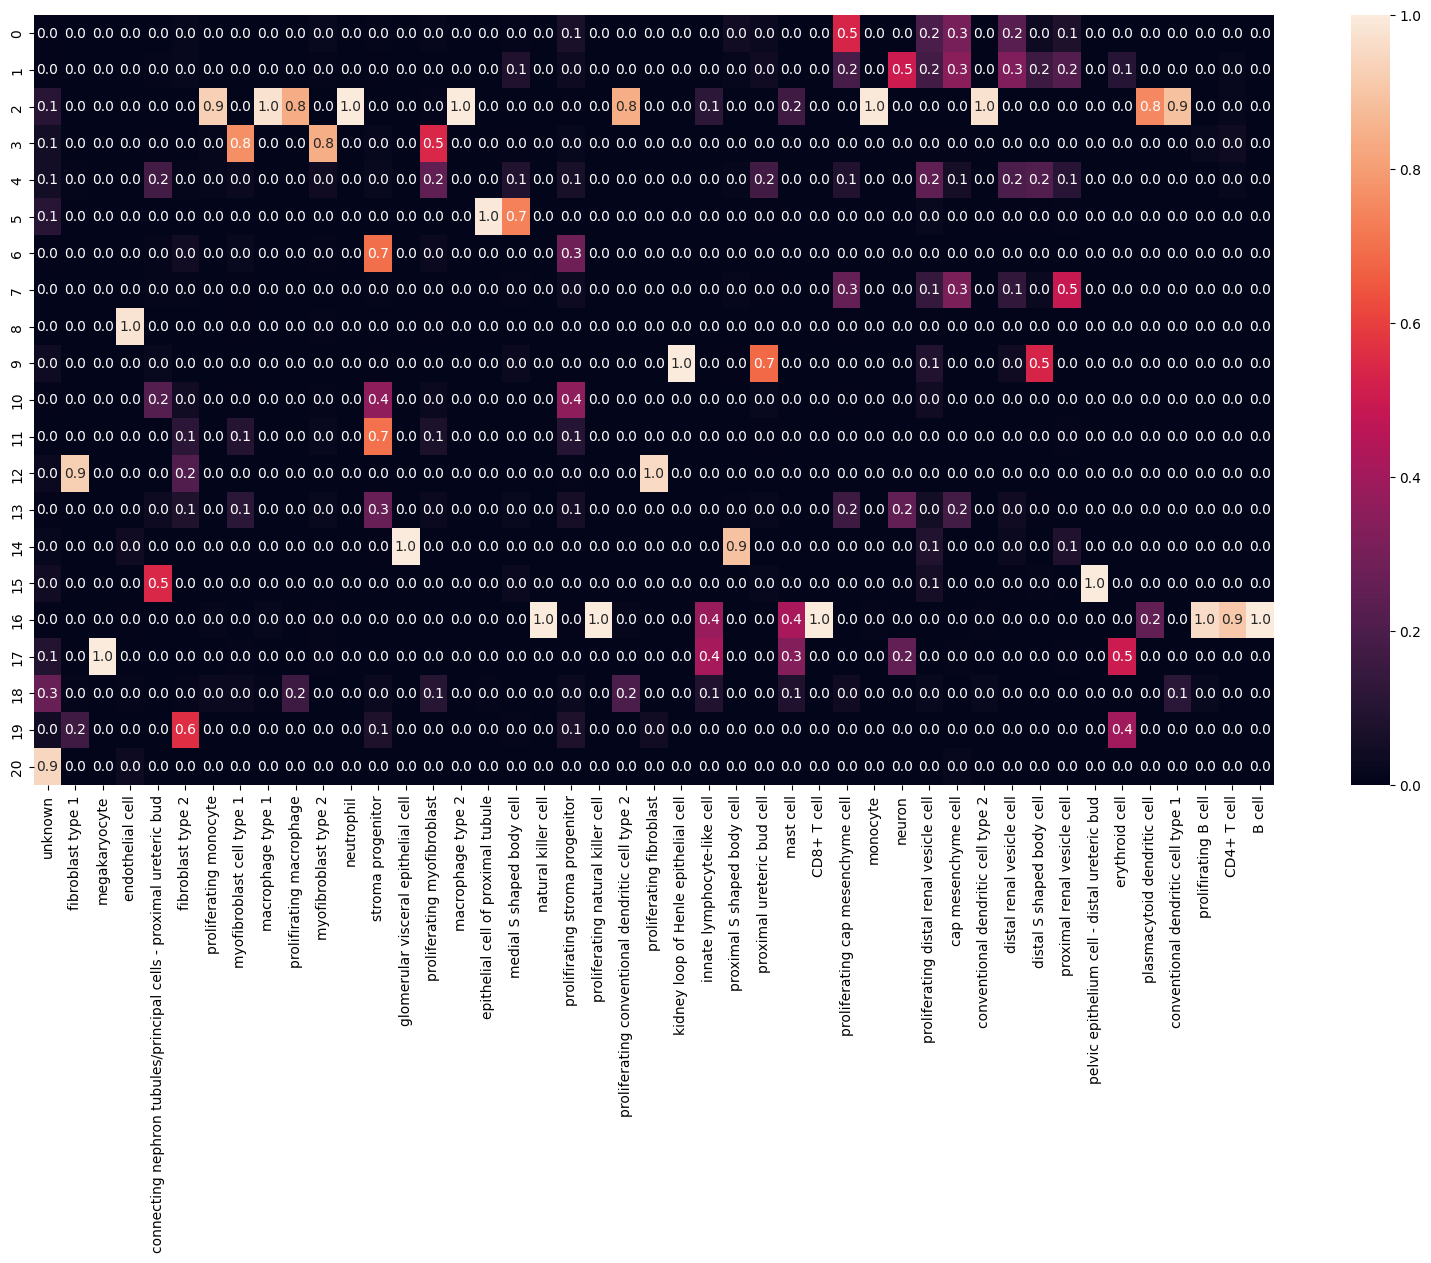

In [107]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata.obs['inferred cell type'].unique()
ys = np.arange(gadata.obs['leiden_gmgm'].nunique())
sns.heatmap(confusion, annot=True, xticklabels=xs, yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

So we do often see lots of strong overlap within clusters. Some clusters seem too coarsly grained - for example, cluster 2 covers monocytes, macrophages, dendritic cells, and neutrophils.  Let's focus in on this cluster and see if further division can separate these cell types.

In [108]:
# AnnData and scanpy are a work-in-progress; at the time of writing this tutorial,
# they do not have great support for the new "array api" of sparse matrices,
# rather still relying on the (long-since-deprecated) "matrix api".
# If we don't cast this to the matrix API, it will cause an error message later.
# This is a technical nuisance that will hopefully be fixed by AnnData fairly soon.
#gadata.obsp["cell_gmgm"] = sparse.csr_matrix(gadata.obsp["cell_gmgm"])


gadata_2 = gadata[gadata.obs["leiden_gmgm"] == "2"]
gadata_2

View of AnnData object with n_obs × n_vars = 705 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[in

In [109]:
sc.tl.leiden(
    gadata_2,
    key_added="leiden_gmgm_2",
    obsp='cell_gmgm'
)
gadata_2

/home/codespace/.python/current/lib/python3.10/site-packages/scanpy/tools/_leiden.py:199: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


AnnData object with n_obs × n_vars = 705 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individual

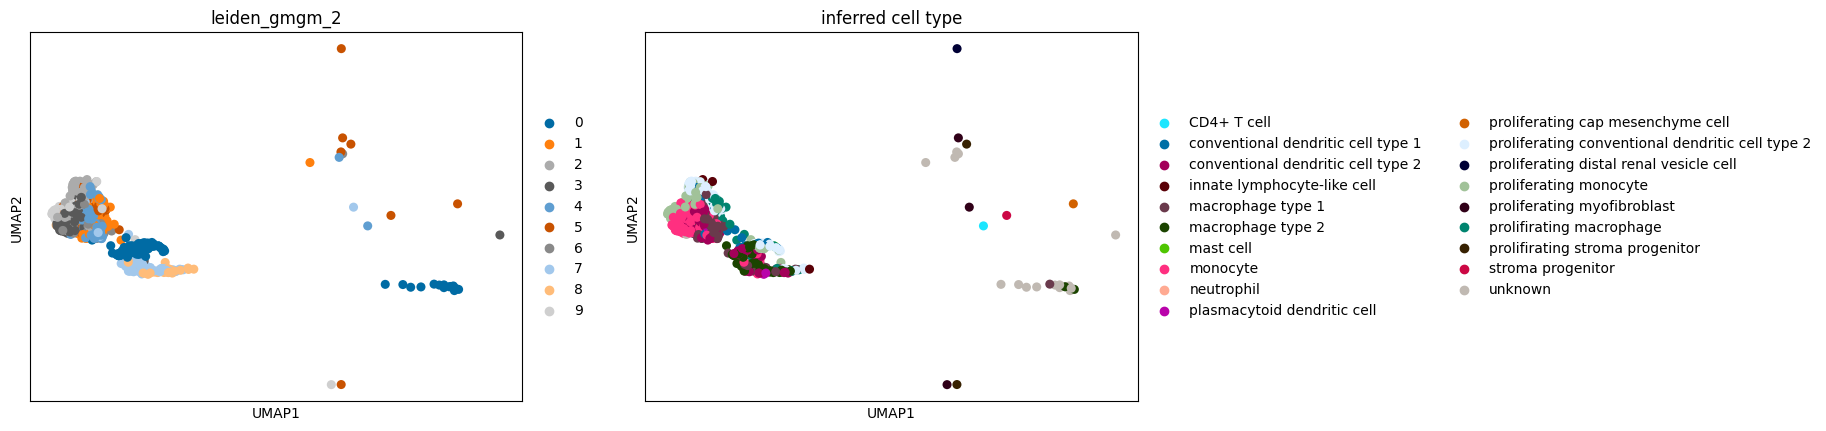

In [110]:
sc.pl.umap(gadata_2, color=['leiden_gmgm_2', 'inferred cell type'])

In [111]:
OVERLAP_METHOD = "overlap"

# Create confusion matrix
confusion = np.zeros((
    gadata_2.obs['leiden_gmgm_2'].nunique(),
    gadata_2.obs['inferred cell type'].nunique()
))

for my_cluster in gadata_2.obs['leiden_gmgm_2'].unique():
    i = int(my_cluster)
    for j, cell_type in enumerate(gadata_2.obs['inferred cell type'].unique()):
        confusion[i, j] = get_overlap(
            set(gadata_2[gadata_2.obs["leiden_gmgm_2"] == my_cluster].obs_names),
            set(gadata_2[gadata_2.obs['inferred cell type'] == cell_type].obs_names),
            OVERLAP_METHOD
        )

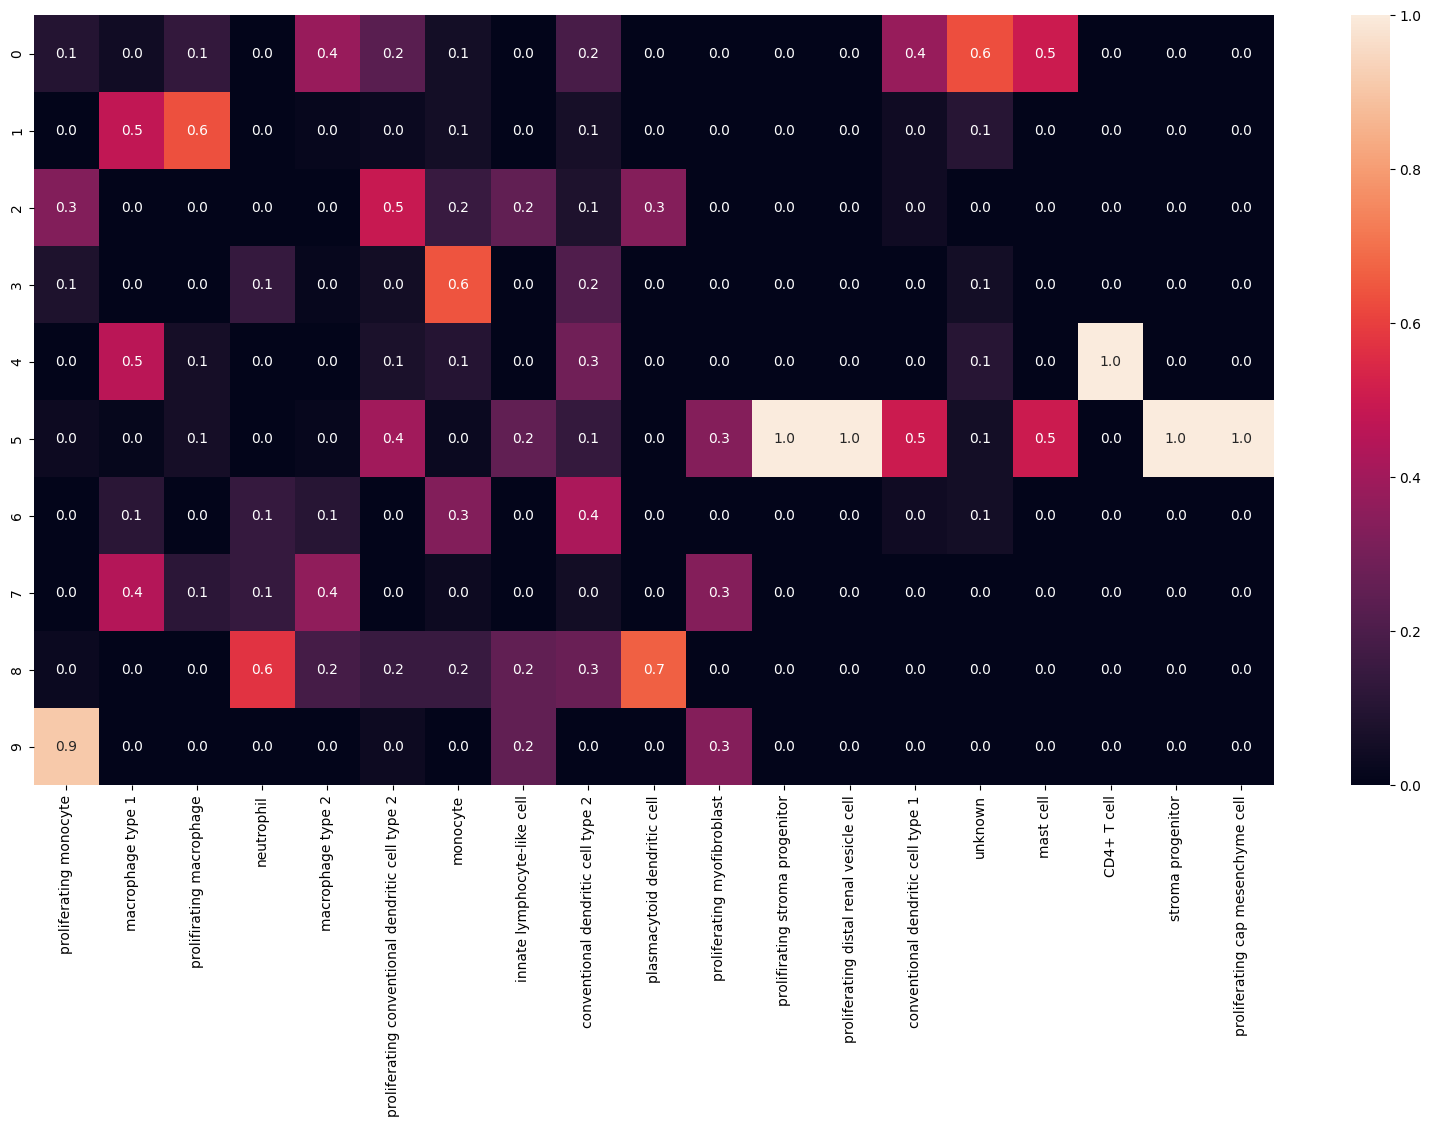

In [112]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['inferred cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
sns.heatmap(confusion, annot=True, xticklabels=xs, yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

Now that we've zoomed in, it's a bit messier - so let's look at the four cell types we mentioned above and see if they are separated.

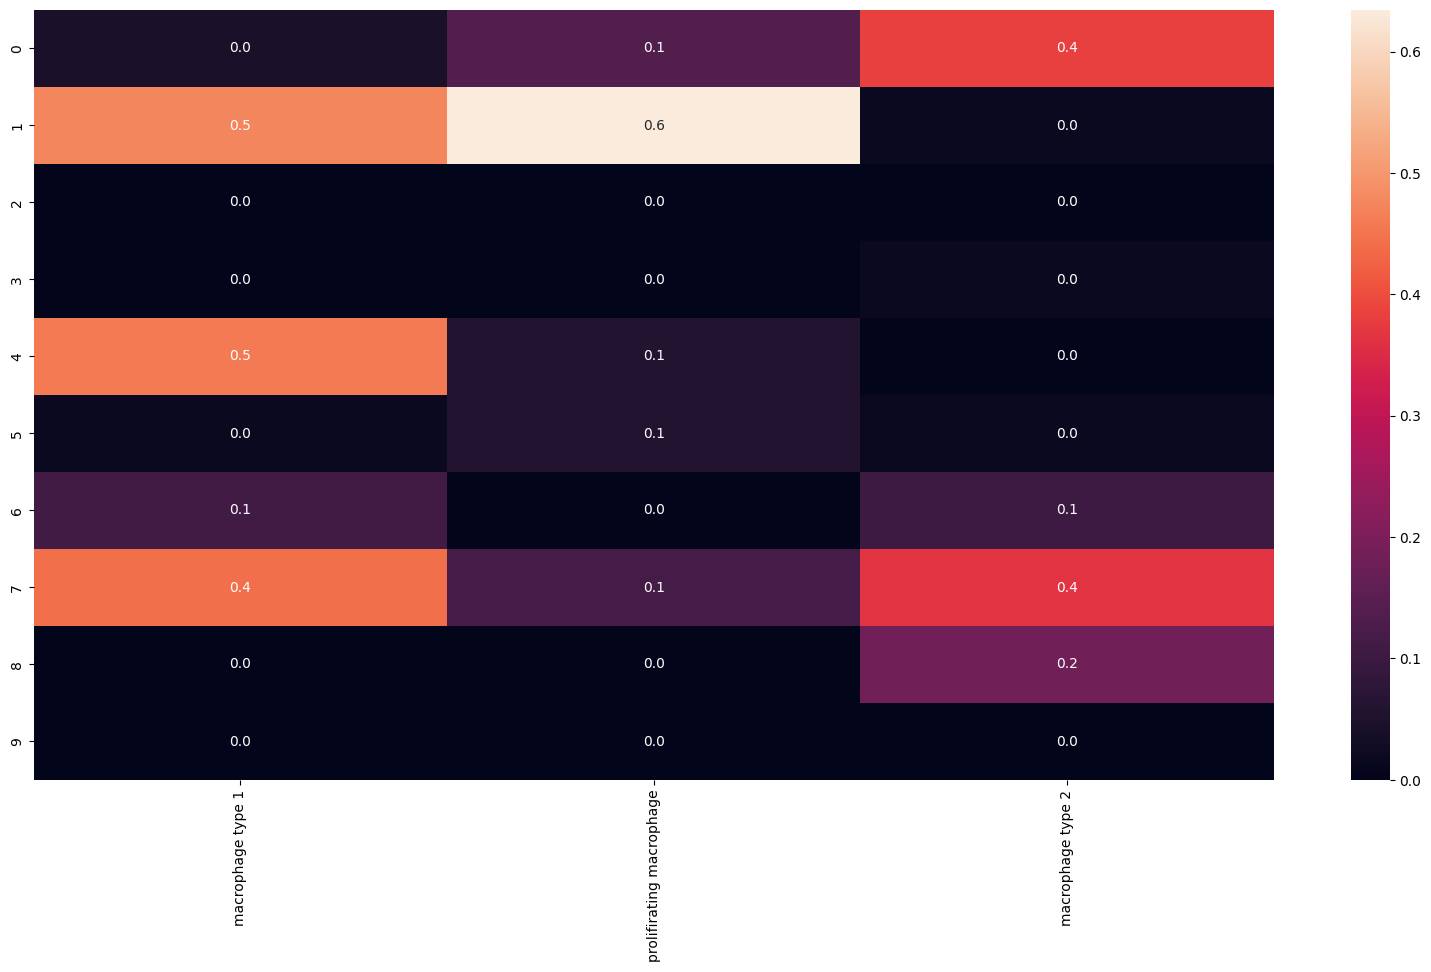

In [113]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['inferred cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
idxs = ['macrophage' in x for x in xs]
sns.heatmap(confusion[:, idxs], annot=True, xticklabels=xs[idxs], yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

Clusters 0, 1, 4, 7 seem to be macrophage-containing.

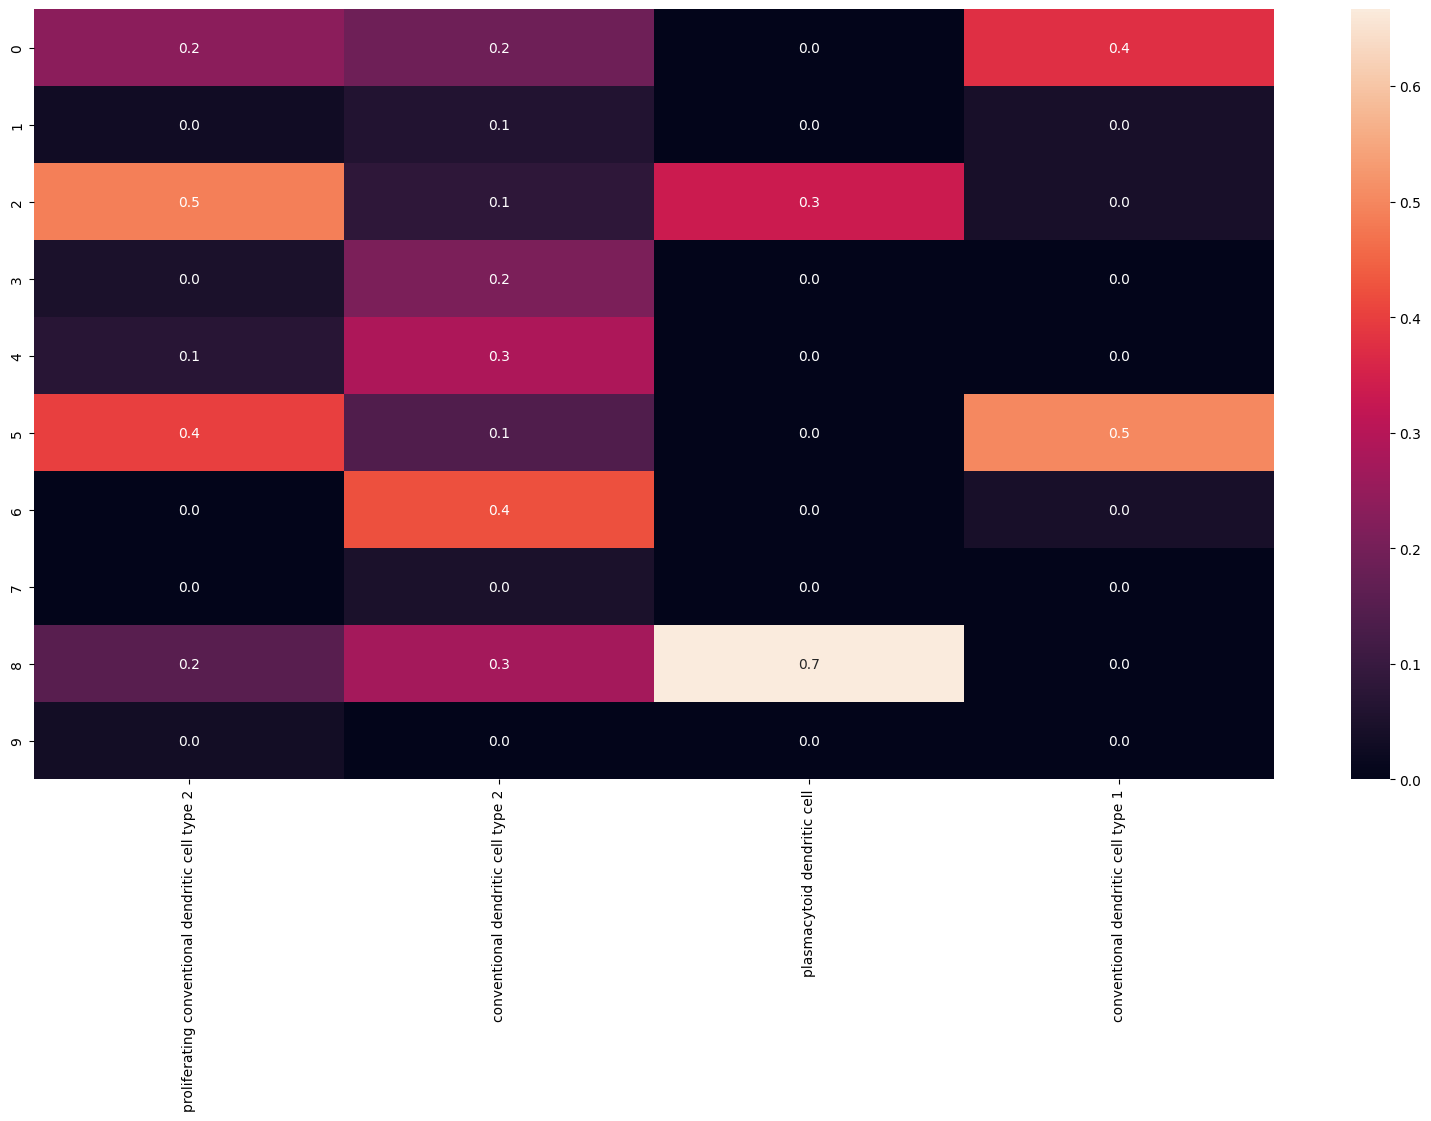

In [114]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['inferred cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
idxs = ['dendritic' in x for x in xs]
sns.heatmap(confusion[:, idxs], annot=True, xticklabels=xs[idxs], yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

Clusters 0, 2, 5, 6, 8 seem to be dendritic-containing.

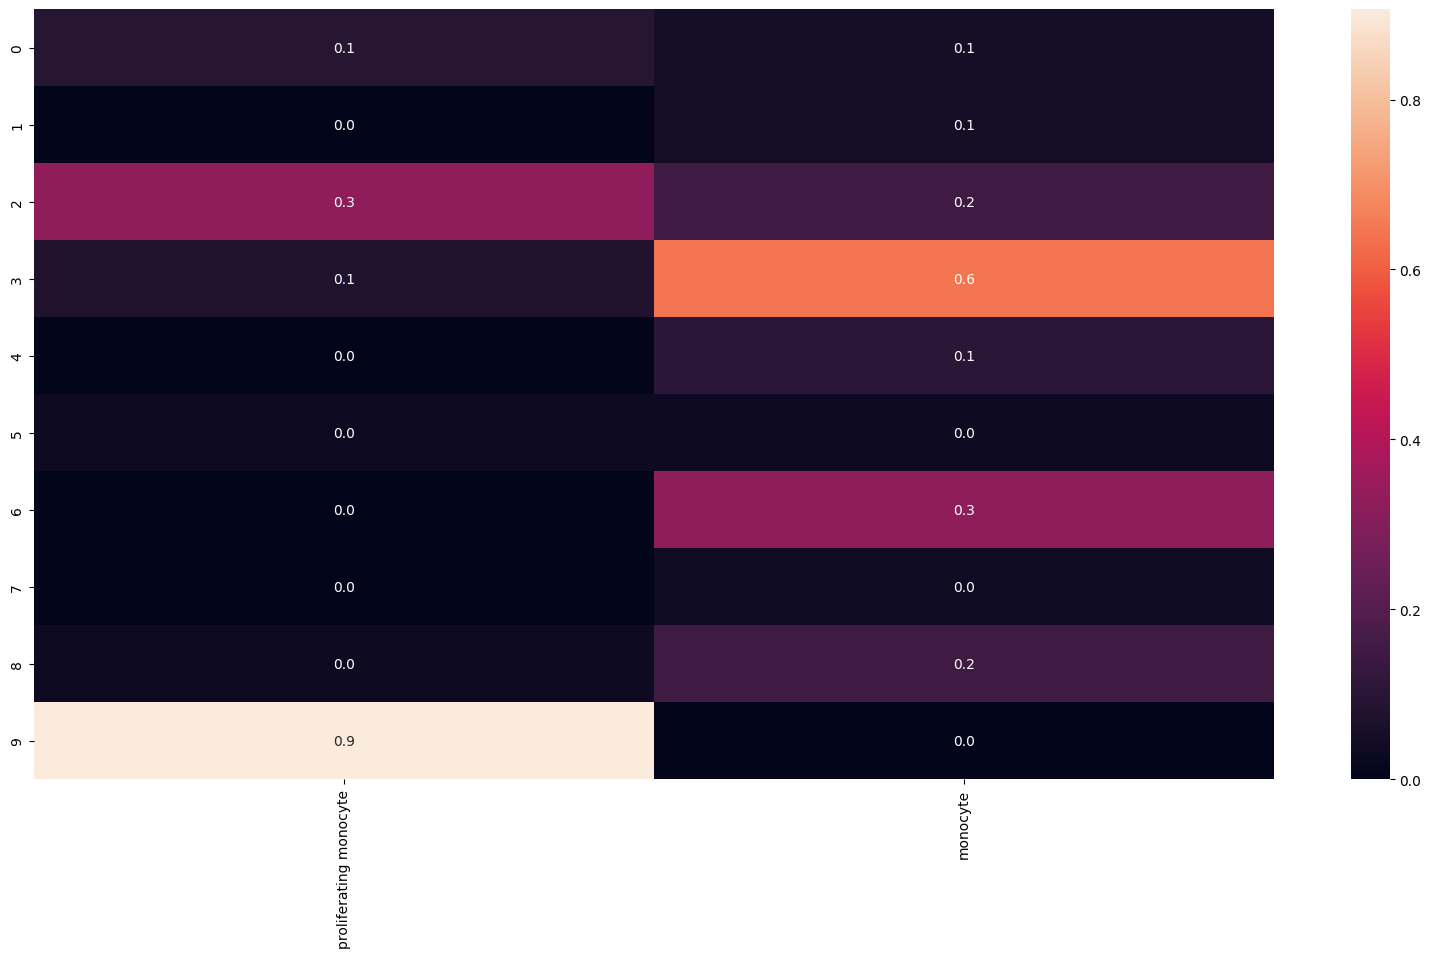

In [115]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['inferred cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
idxs = ['monocyte' in x for x in xs]
sns.heatmap(confusion[:, idxs], annot=True, xticklabels=xs[idxs], yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

Clusters 3, 9 seem to be monocyte-containing.

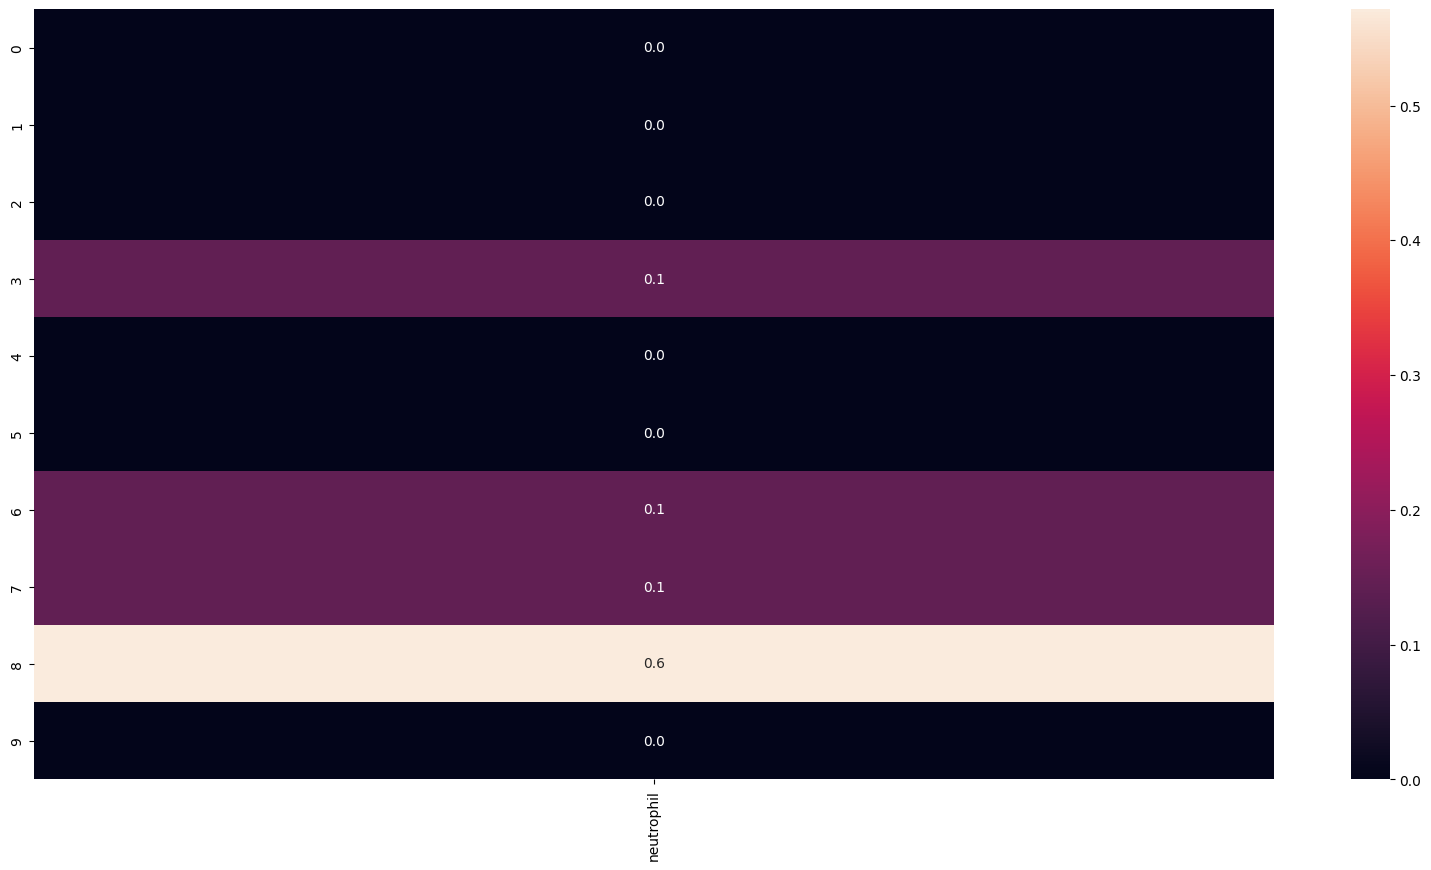

In [116]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['inferred cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
idxs = ['neutrophil' in x for x in xs]
sns.heatmap(confusion[:, idxs], annot=True, xticklabels=xs[idxs], yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

Final results:

0) Macrophage, Dendritic

1) Macrophage

2) Dendritic

3) Monocyte

4) Macrophage (+ t cells)

5) Dendritic (+ proliferating and progenitor cells)

6) Dendritic

7) Macrophage

8) Neutrophil, Dendritic

9) Monocyte

The cells in parentheses are 'contaminants'; they are present in very low quantities in this cluster, which can be seen by looking with Jaccard similarity (below).  Overlap similarity, what we were using before, is maximized when one class is contained in the other - so if there is only 1 T cell, then it will have a high overlap with whatever cluster it happens to be assigned with.  This is useful in trying to find out which clusters contain which cell types, but is susceptible to this small-class problem.  Jaccard, on the other hand, is maximized when the classes are equal - not just contained in one another.

In [117]:
OVERLAP_METHOD = "jaccard"

# Create confusion matrix
confusion = np.zeros((
    gadata_2.obs['leiden_gmgm_2'].nunique(),
    gadata_2.obs['inferred cell type'].nunique()
))

for my_cluster in gadata_2.obs['leiden_gmgm_2'].unique():
    i = int(my_cluster)
    for j, cell_type in enumerate(gadata_2.obs['inferred cell type'].unique()):
        confusion[i, j] = get_overlap(
            set(gadata_2[gadata_2.obs["leiden_gmgm_2"] == my_cluster].obs_names),
            set(gadata_2[gadata_2.obs['inferred cell type'] == cell_type].obs_names),
            OVERLAP_METHOD
        )

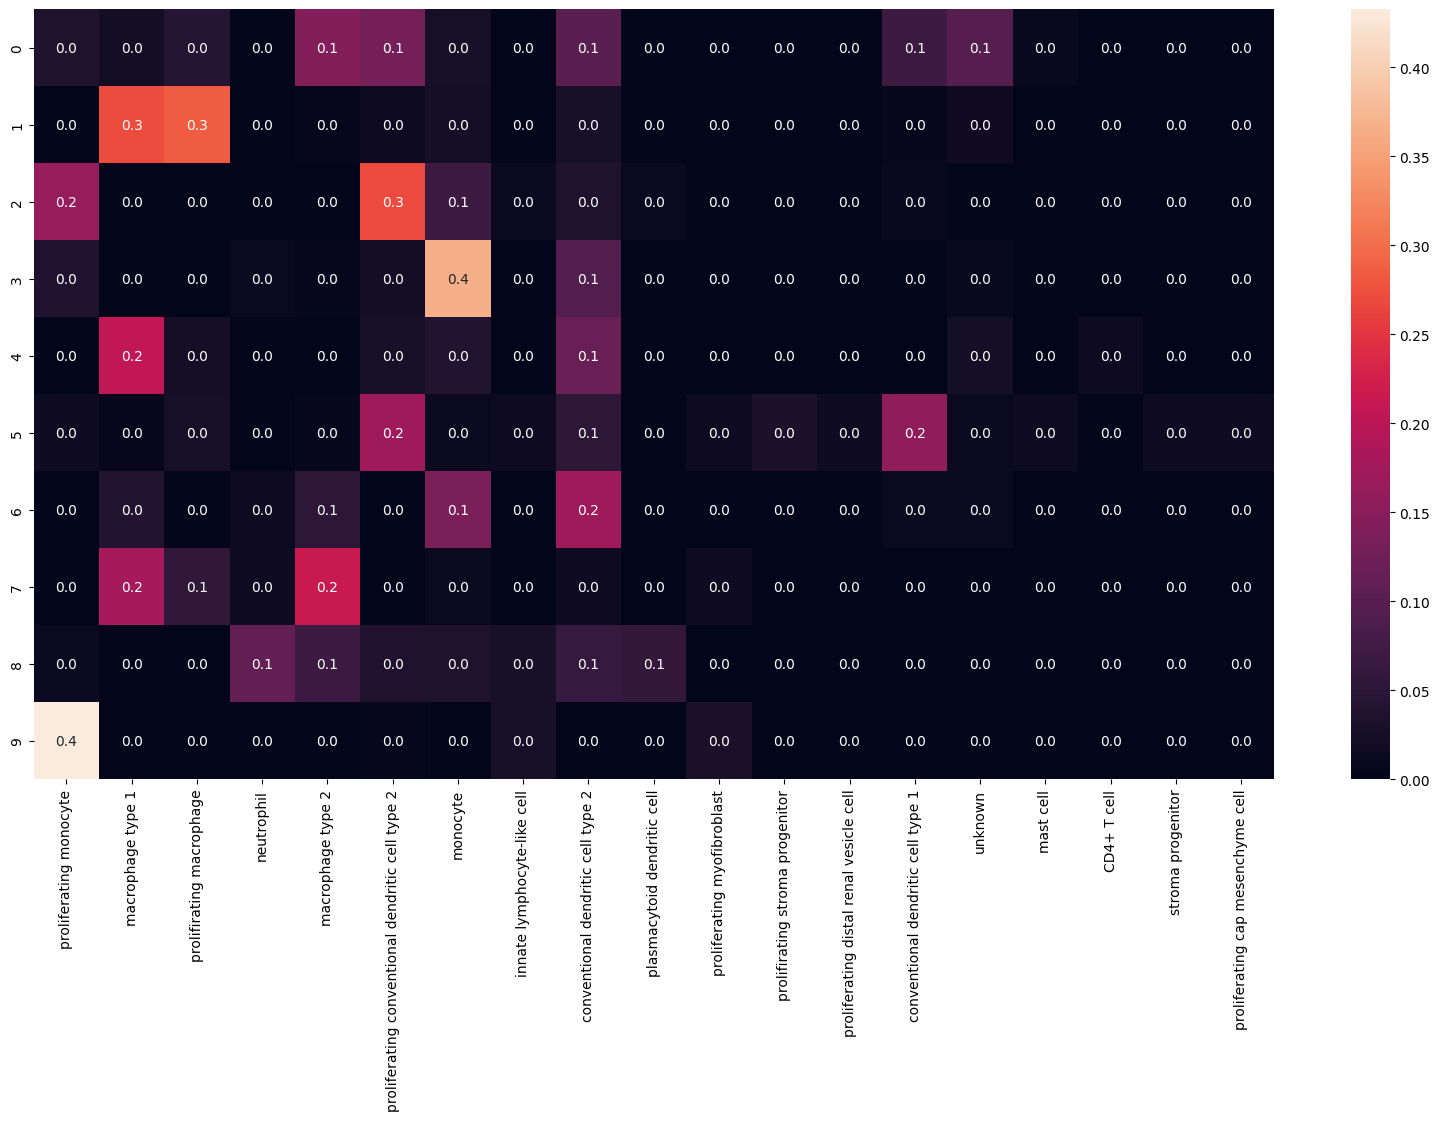

In [118]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['inferred cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
sns.heatmap(confusion, annot=True, xticklabels=xs, yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

# Gene analysis

This is somewhat limited by our filtering out of genes.  Try re-running the algorithm with less filtered out to investigate other gene groups!

In [119]:
shape_palette = 100*[
   "circle",
   "rect",
   "diamond",
   "triangle",
   "rect",
   "circle",
   "triangle"
]
color_palette = 100*[
   "#FF9A96",
   "#264589",
   "#FF9A96",
   "#264589",
   "#FF9A96",
   "#264589",
   "#FF9A96"
]


def plot_info(
   name: str,
   adata: ad.AnnData,
   no_edge_weights: bool = True,
   layout: Optional[str] = None,
   graph_type: Literal['gmgm', 'glasso'] = 'gmgm'
) -> tuple[plt.Figure, plt.Axes]:
   graph = adata.obsp[f'gene_{graph_type}']
   how_many = graph.shape[0]

   try:
       # If the graph is empty, this throws an error!
       graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected")
   except:
       graph = ig.Graph.Weighted_Adjacency(graph)
   graph.vs["label"] = (
       adata.obs["external_gene_name"].astype(str)
       + "\n("
       + adata.obs_names.str.split('ENSG00000').str[-1]
       + ")"
   )
   graph.vs["label_size"] = 5

   # Get connected components of the graph
   components = graph.components()

   # Color vertex by component
   graph.vs["color"] = [color_palette[i] for i in components.membership]

   # Change  vertex shape by component as well
   graph.vs["shape"] = [shape_palette[i] for i in components.membership]

   graph.es["label"] = [f"{w:.2E}" for w in graph.es["weight"]]
   graph.es["label_size"] = 5

   if layout is None:
       layout = 'circle' if how_many > 15 else 'kk'


   fig, ax = plt.subplots(figsize=(7, 7))
   ig.plot(
       graph,
       vertex_size=40,
       target=ax,
       edge_color="black",
       layout=layout,
       **({} if no_edge_weights else {'edge_label': graph.es["label"]}),
   )
   ax.set_facecolor("white")
   ax.set_title(name)
   ax.set_xlabel("Colored/shaped by connected components")


   fig.suptitle(f"Connections of {name}")
   return fig, ax

#fbdata.obsp["gene_gmgm"] = sparse.csr_matrix(fbdata.obsp["gene_gmgm"])

/tmp/ipykernel_2612/2962093591.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (
/tmp/ipykernel_2612/2962093591.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (


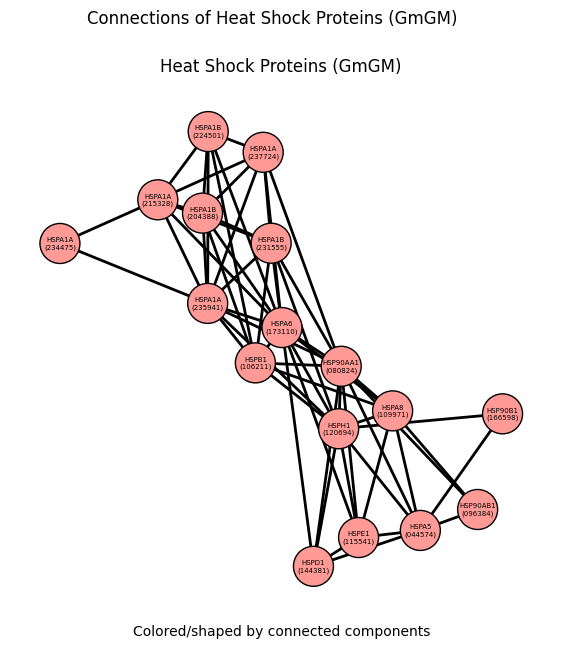

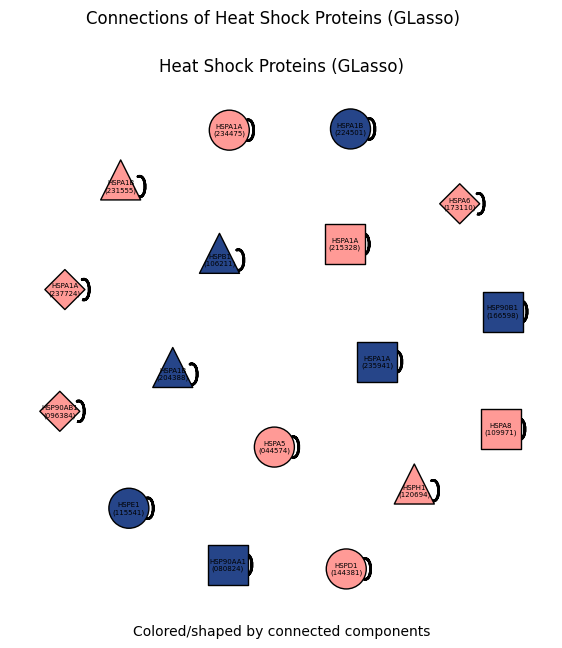

In [120]:
hsp = fbdata[fbdata.obs["external_gene_name"].str.startswith("HSP")]

plot_info(
   "Heat Shock Proteins (GmGM)",
   hsp,
   layout='fr',
   graph_type='gmgm'
)
plot_info(
   "Heat Shock Proteins (GLasso)",
   hsp,
   layout='fr',
   graph_type='glasso'
)
pass

/tmp/ipykernel_2612/2962093591.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (
/tmp/ipykernel_2612/2962093591.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (


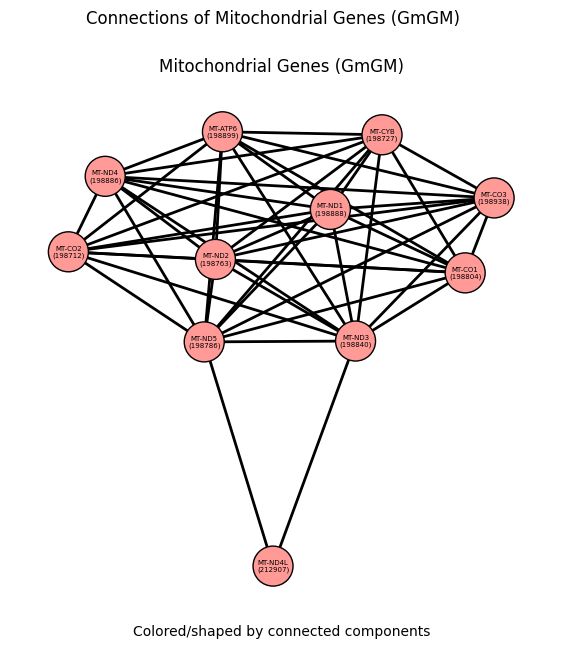

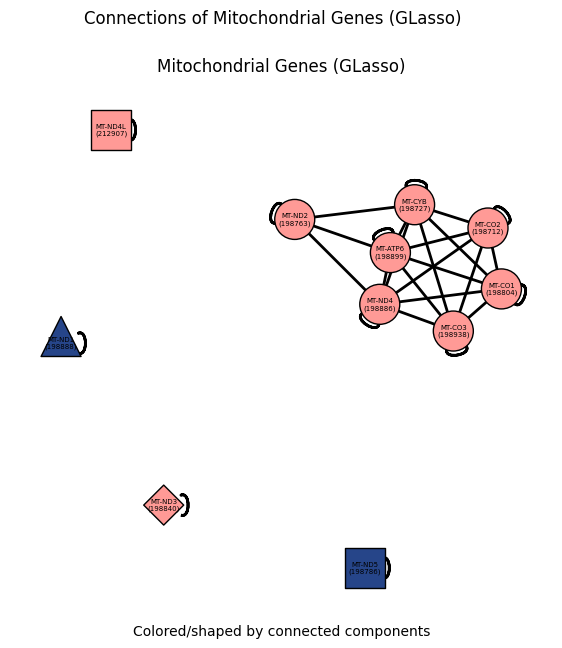

In [121]:
mitochondrial = fbdata[fbdata.obs["external_gene_name"].str.startswith("MT-")]

plot_info(
   "Mitochondrial Genes (GmGM)",
   mitochondrial,
   layout='fr',
   graph_type='gmgm'
)
plot_info(
   "Mitochondrial Genes (GLasso)",
   mitochondrial,
   layout='fr',
   graph_type='glasso'
)
pass

/tmp/ipykernel_2612/2962093591.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (
/tmp/ipykernel_2612/2962093591.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (


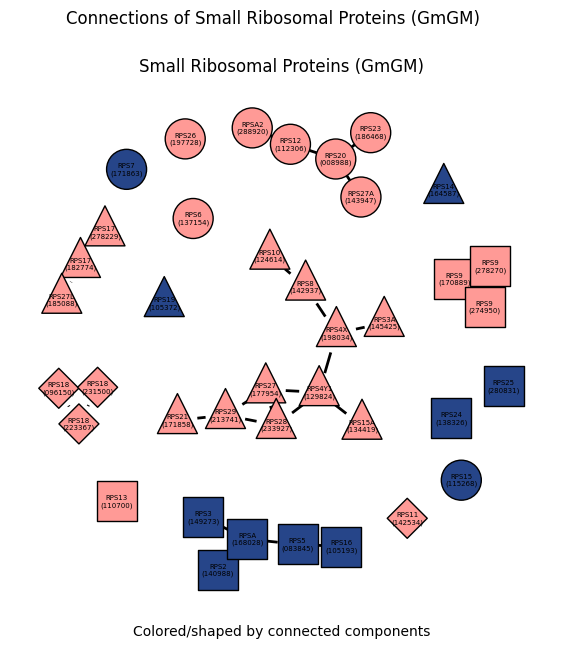

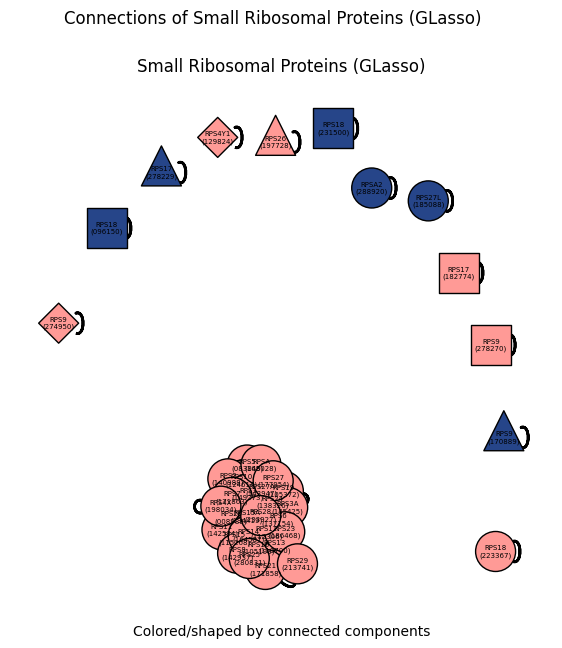

In [122]:
rps = fbdata[fbdata.obs["external_gene_name"].str.startswith("RPS")]

plot_info(
   "Small Ribosomal Proteins (GmGM)",
   rps,
   layout='fr',
   graph_type='gmgm'
)
plot_info(
   "Small Ribosomal Proteins (GLasso)",
   rps,
   layout='fr',
   graph_type='glasso'
)
pass

/tmp/ipykernel_2612/2962093591.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (
/tmp/ipykernel_2612/2962093591.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (


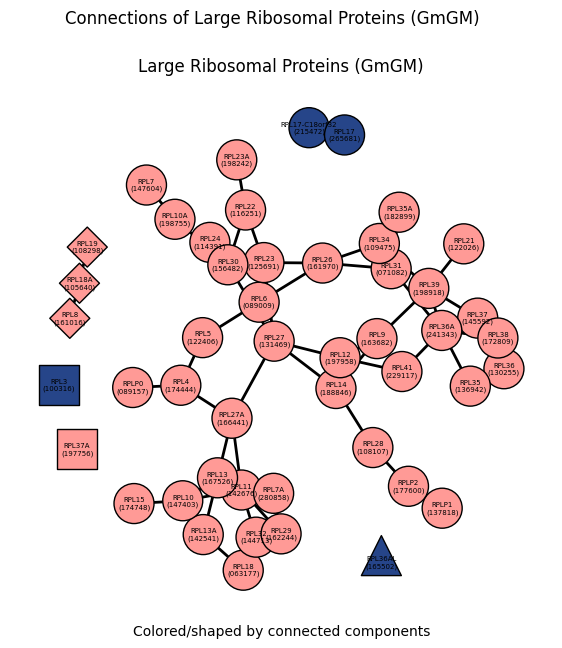

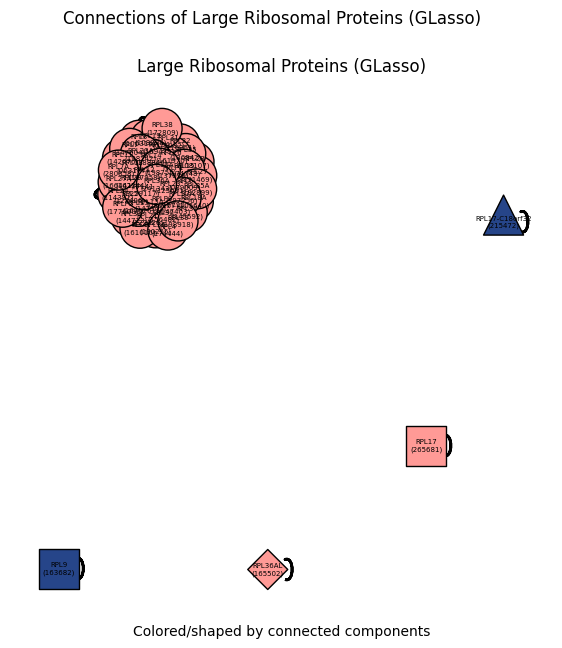

In [123]:
rpl = fbdata[fbdata.obs["external_gene_name"].str.startswith("RPL")]

plot_info(
   "Large Ribosomal Proteins (GmGM)",
   rpl,
   layout='fr',
   graph_type='gmgm'
)
plot_info(
   "Large Ribosomal Proteins (GLasso)",
   rpl,
   layout='fr',
   graph_type='glasso'
)
pass